# selectfeatures
This notebook shows the development of how we shrink the size of features from `seekfeatures` to study with. We used the following method to analyze the weight of each feature:

* RIDGE (Ridge Regression)
* LASSO (Least Absolute Shrinkage and Selection Operator)
* Random Forest
* RFECV (Recursive Feature Elimination with Cross-validation)

We use MSE to compare and evaluate these methods for final decision making.<br>

#### Use ``ChemFeatures`` to generate a dataframe of features.

In [1]:
import pandas as pd
# Module for extracting ChemInfo
from seekfeatures import *
import mordred
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# plotting package
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
# Use 100K data for demonstration
data = pd.read_csv('../Database/HCEPD_100K.csv') 
# randomly choose 50 data to illustrate the analysis
data50 = data.sample(frac=0.0005, replace=True, random_state=1)
data50.head()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
0,655365,C1C=CC=C1c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,C18H9N3OSSe,394.3151,5.161953,0.867601,91.567575,-5.467601,2.022944,-3.444656,C1=CC=C(C1)c1cc2[se]c3c4occc4c4nsnc4c3c2cn1
1,1245190,C1C=CC=C1c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH2]...,C22H15NSeSi,400.4135,5.261398,0.504824,160.401549,-5.104824,1.630750,-3.474074,C1=CC=C(C1)c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH...
2,21847,C1C=c2ccc3c4c[nH]cc4c4c5[SiH2]C(=Cc5oc4c3c2=C1...,C24H17NOSi,363.4903,0.000000,0.000000,197.474780,-4.539526,1.462158,-3.077368,C1=CC=C(C1)C1=Cc2oc3c(c2[SiH2]1)c1c[nH]cc1c1cc...
3,65553,[SiH2]1C=CC2=C1C=C([SiH2]2)C1=Cc2[se]ccc2[SiH2]1,C12H12SeSi3,319.4448,6.138294,0.630274,149.887545,-5.230274,1.682250,-3.548025,C1=CC2=C([SiH2]1)C=C([SiH2]2)C1=Cc2[se]ccc2[Si...
4,720918,C1C=c2c3ccsc3c3[se]c4cc(oc4c3c2=C1)C1=CC=CC1,C20H12OSSe,379.3398,1.991366,0.242119,126.581347,-4.842119,1.809439,-3.032680,C1=CC=C(C1)c1cc2[se]c3c4sccc4c4=CCC=c4c3c2o1


Generate a dataframe of chemical features by `seek_feature_with_replacement` where all missing values are replaced.

In [85]:
features_df = seek_feature_with_replacement(data50['SMILES_str'])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  6.76it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.39it/s]


In [86]:
features_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,20.142136,16.169815,0,0,33.204238,2.616114,5.057172,33.204238,1.383510,4.188377,...,10.460213,77.559765,394.963154,11.968580,1216,42,146.0,185.0,4.611111,5.000000
1,20.849242,16.133746,0,0,34.755190,2.600656,5.047921,34.755190,1.390208,4.221130,...,10.493799,77.890806,401.013897,10.025347,1337,45,150.0,189.0,4.861111,5.250000
2,22.889683,17.893320,0,0,37.437727,2.645420,5.160050,37.437727,1.386582,4.315006,...,10.639862,82.032579,363.107941,8.252453,1635,49,168.0,215.0,5.083333,5.555556
3,13.313708,11.688393,0,0,21.283525,2.481194,4.637583,21.283525,1.330220,3.777767,...,9.782393,66.966647,319.941201,11.426471,430,20,94.0,115.0,3.166667,3.333333
4,19.435029,15.989365,0,0,31.670490,2.627835,5.062549,31.670490,1.376978,4.154569,...,10.429310,77.119188,379.977407,10.856497,1074,39,142.0,181.0,4.361111,4.750000


<br>

### Prepare Data for Regression
Use `Processing` to standardize the features data, and applies KFold cross-validation to split the data.
> `Processing.scale_sample` is a standard scaler to the data.<br>
> `Processing.kfFold_sampling` uses KFold CV method to split the data into train set and test set.<br>
> `Processing.sampleprocessor` contains both funcionalities above and generates automatically train set and test set for users.


In [87]:
from processing import *

In [88]:
# the first argument is input of orginal dataframe, the second one
# is  the generated features dataframe.
X, y = scale_sample(data50, features_df)

In [89]:
X_train, X_test, y_train, y_test = kfold_sampling(X, y, n = 10)

In [90]:
# SampleProcessor contains functionality of both standardscaler and KFold splitting.
X_train, X_test, y_train, y_test = sample_processor(data, features_df, n = 10)

In [91]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

45 5 45 5


### Linear regression model
Here, we chose two most commonly used linear regression models to shrink the coefficients: Ridge and LASSO. Both of them describes the weights of each feature contributing to the response in a linear model, and introduce a penalty term (&lambda;) to include the error from the magnitude of feature coefficient. The difference between them is the way they calculate the penalty. While RIDGE tries to shrink all coefficients closer to zero due to its square term, LASSO takes the absolutie value of coef to eliminate some 0 term and leave the significant term.<br>

We applied both methods to our dataset and tried to compare them by plotting error vs r2. They are included in ``ShrinkCoef``. Users can also decide which one to use for their data by calling these functions. 

* **Ridge regression (RR)**

In [100]:
from rrmodel import *

In [101]:
# a and b are optional if only one set of data is given.
coefs_RR, lambdas_RR, error1_RR, error2_RR, modelRR = rr_regress(X_train, y_train, a = X_test, b = y_test)

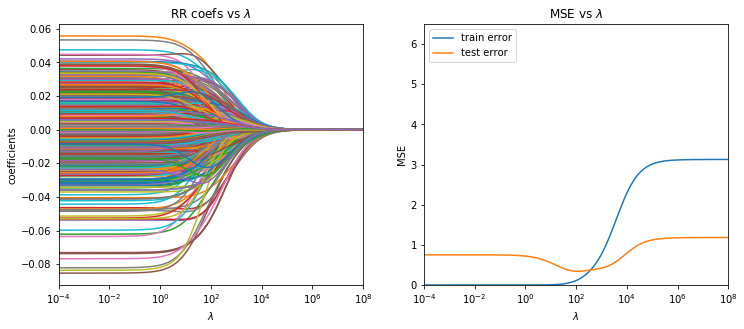

In [102]:
rr_plot(X_train, y_train, a = X_test, b = y_test)

In [103]:
# choose lambda = 1e-2 and find coef.
lam = list(lambdas_RR)[34]
coefs_RR[34]

array([ 2.25584662e-03, -1.56423861e-03,  0.00000000e+00, ...,
       -9.15744509e-05,  6.91773598e-03,  5.97871386e-03])

In [104]:
# complie all coef at lambda = 1e-2 into a dataframe 
RR_df = pd.DataFrame({'Feature':features_df.columns.values, 'coefs_RR':coefs_RR[34]}).sort_values('coefs_RR',ascending=False)
RR_df.head()

,Feature,coefs_RR
241,ATSC8c,0.055745
1517,PEOE_VSA2,0.053374
349,AATSC8c,0.047509
606,GATS6se,0.044827
505,MATS1se,0.044248


* **LASSO regression**

In [105]:
from lassomodel import *

In [106]:
# a and b are optional if only one set of data is given.
coefs_LASSO, lambdas_LASSO, error1_LASSO, error2_LASSO, modelLASSO = \
  lasso_regress(X_train, y_train, a = X_test, b = y_test)\

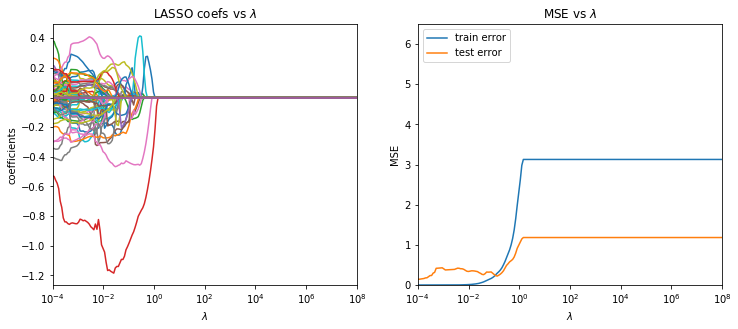

In [107]:
lasso_plot(X_train, y_train, a = X_test, b = y_test)

LASSO has difficulty in converging the coefficients and returns an odd plot. The random error mainly comes from its strategy that taking absolute value of coefficients.

### Tree Based Methods
In addition to linear and non-linear regression, tree based model provides a more flexible method to describe the bonding between features and our target. 

* **Random Forest**

In [108]:
from rfmodel import *


In [109]:
modelRF, RF_fit =  rf_regress(X, y)

# We can get coefs of each feature from RFrank
RFrank = modelRF.feature_importances_

In [110]:
RF_df = pd.DataFrame({'Feature':features_df.columns.values, 'Rank':RFrank}).sort_values('Rank',ascending=False)
RF_df.head()

,Feature,Rank
537,MATS1i,0.240323
333,ATSC1i,0.125228
441,AATSC1i,0.064410
505,MATS1se,0.063984
1584,MDEN-22,0.062288


RF error for train set 0.17936321970979546
testset error 0.1953851432781714


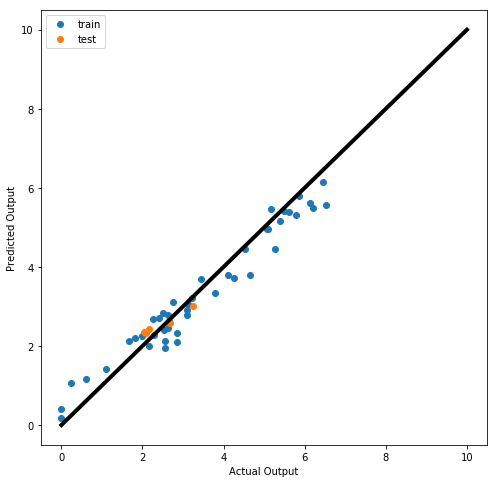

In [111]:
rf_plot(X_train, y_train, a = X_test, b = y_test,
        name1 = 'train', name2 = 'test')

### Recursive Feature Elimination (RFE)

Lastly, we also take advantage from a built-in function from sklearn ``RFE``, which returns a ranking of features that help user to choose from. It repeatedly performs learning process based on specified estimator (such as 'linear') and in each iteration, eliminates the least significant features based on coef_ and score (by specified scoring method). The repeating process runs through the entire input data until all the features have been analyzed. ``RFECV`` applies cross-validation strategy to iteration sampling and returns a cross-validated ranking of features.

Optimal number of features : 60
[False False False ... False False False]


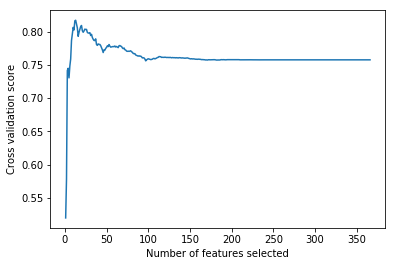

In [112]:
from rfecvmodel import *
modelRFECV = rfecv_regress(X, y, step = 5, estimator = 'linear', scoring_method='explained_variance' )

In [132]:
# The result from the model above is stored in modelRFECV
# call the resulting coefficient for each featrue
coef_list = [x for x in modelRFECV.estimator_.coef_[0]]

Users can generate use this c

In [149]:
# obtain coefficients of each feature
RFECVrank = modelRFECV.ranking_
features60 = pd.DataFrame({'Feature':features_df.columns.values, 'Rank':RFECVrank}).sort_values('Rank')
features_title = features60.Feature[0:60].values
# Compile into a dataframe
RFECV_df = pd.DataFrame()
RFECV_df['coef'] = coef_list
RFECV_df['Feature'] = [x for x in features_title]

# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame({'Feature':RFECV_df.Feature, 'Coef':RFECV_df.coef})

# Sort the dataframe
meanplot = meanplot.sort_values('Coef', ascending=False)

import seaborn as sns
sns.set(font_scale=2)
sns.set_style('whitegrid') 
coef_plot = sns.factorplot(y = 'Coef' , x = 'Feature', data = meanplot, kind = "bar", 
               size = 14, aspect = 1.9, orient = "v" , palette = 'coolwarm')
coef_plot.set_xticklabels(rotation = 90, size = 20)
coef_plot.set_yticklabels(size = 20)
 

As suggested by RFECV result, we can select the 60 features with highest scores.

### Model Selection

In [157]:
def snsplot(X,y,features_df):
    modelRFECV = rfecv_regress(X, y)
    RFECVrank = modelRFECV.ranking_
    features60 = pd.DataFrame({'Feature':features_df.columns.values, 'Rank':RFECVrank}).sort_values('Rank')
    features_title = features60.Feature[0:60].values

    # Compile into a dataframe
    RFECV_df = pd.DataFrame()
    RFECV_df['coef'] = coef_list
    RFECV_df['Feature'] = [x for x in features_title]

    # Put the mean scores into a Pandas dataframe
    meanplot = pd.DataFrame({'Feature':RFECV_df.Feature, 'Coef':RFECV_df.coef})

    # Sort the dataframe
    meanplot = meanplot.sort_values('Coef', ascending=False)

    import seaborn as sns
    sns.set(font_scale=2)
    sns.set_style('whitegrid') 
    coef_plot = sns.factorplot(y = 'Coef' , x = 'Feature', data = meanplot, kind = "bar", 
                               size = 14, aspect = 1.9, orient = "v" , palette = 'coolwarm')
    coef_plot.set_xticklabels(rotation = 90, size = 20)
    coef_plot.set_yticklabels(size = 20)

Optimal number of features : 60
[False False False ... False False False]


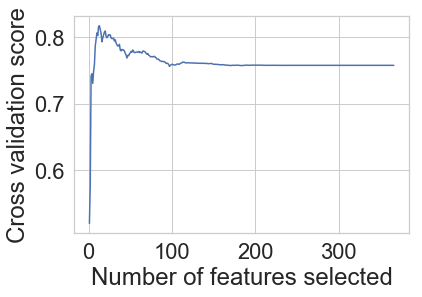

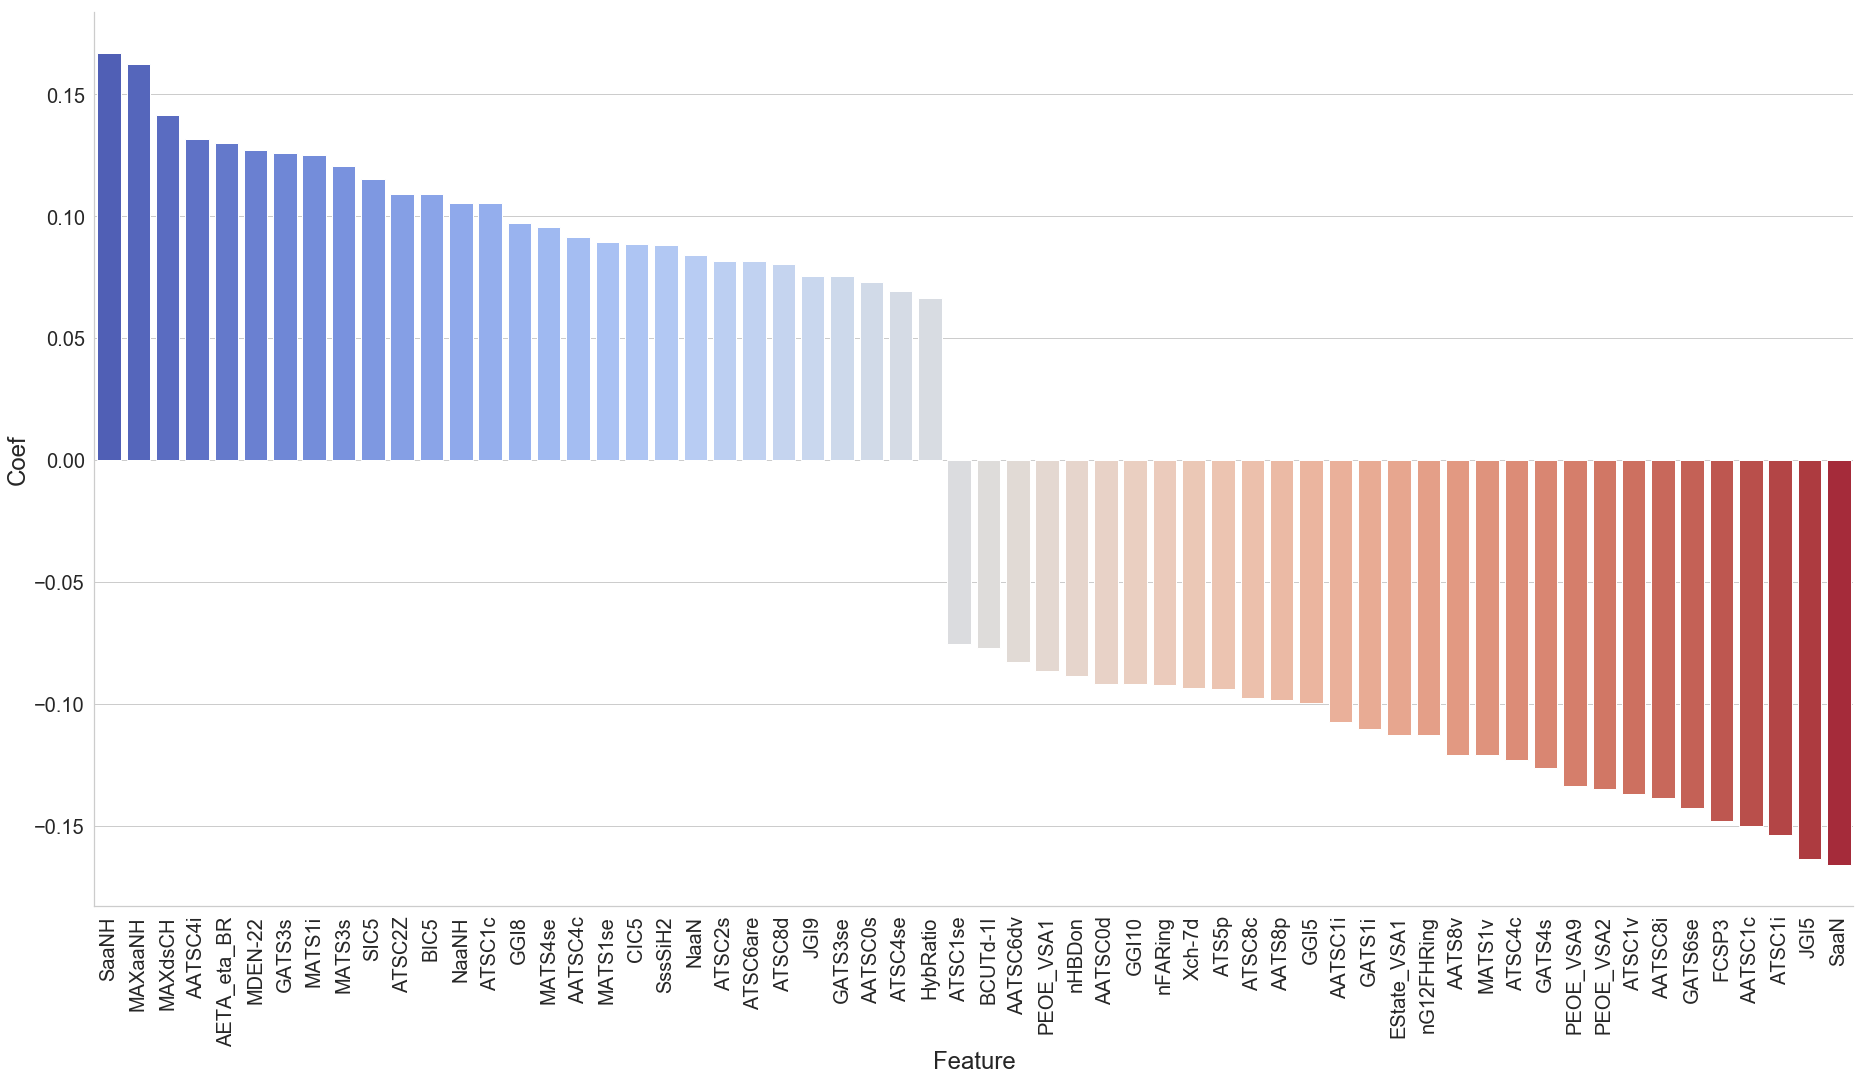

In [158]:
snsplot(X,y,features_df)